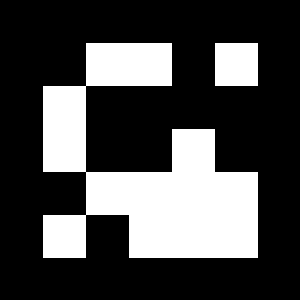

In [61]:
import cv2
from cv2 import aruco
import numpy as np

# Define the dictionary
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_5X5_250)

# Set marker ID and size
marker_id = 42
marker_size = 300  # pixels

# Create an empty image to draw the marker
marker_image = np.zeros((marker_size, marker_size), dtype=np.uint8)

# Generate the marker image
aruco.generateImageMarker(aruco_dict, marker_id, marker_size, marker_image, 1)

# Save the image
cv2.imwrite("aruco_5x5_250_id42.png", marker_image)

image = Image.open("aruco_5x5_250_id42.png").convert("RGBA")  # PNG supports transparency


display(image)

In [22]:
img.size

(2500, 1768)

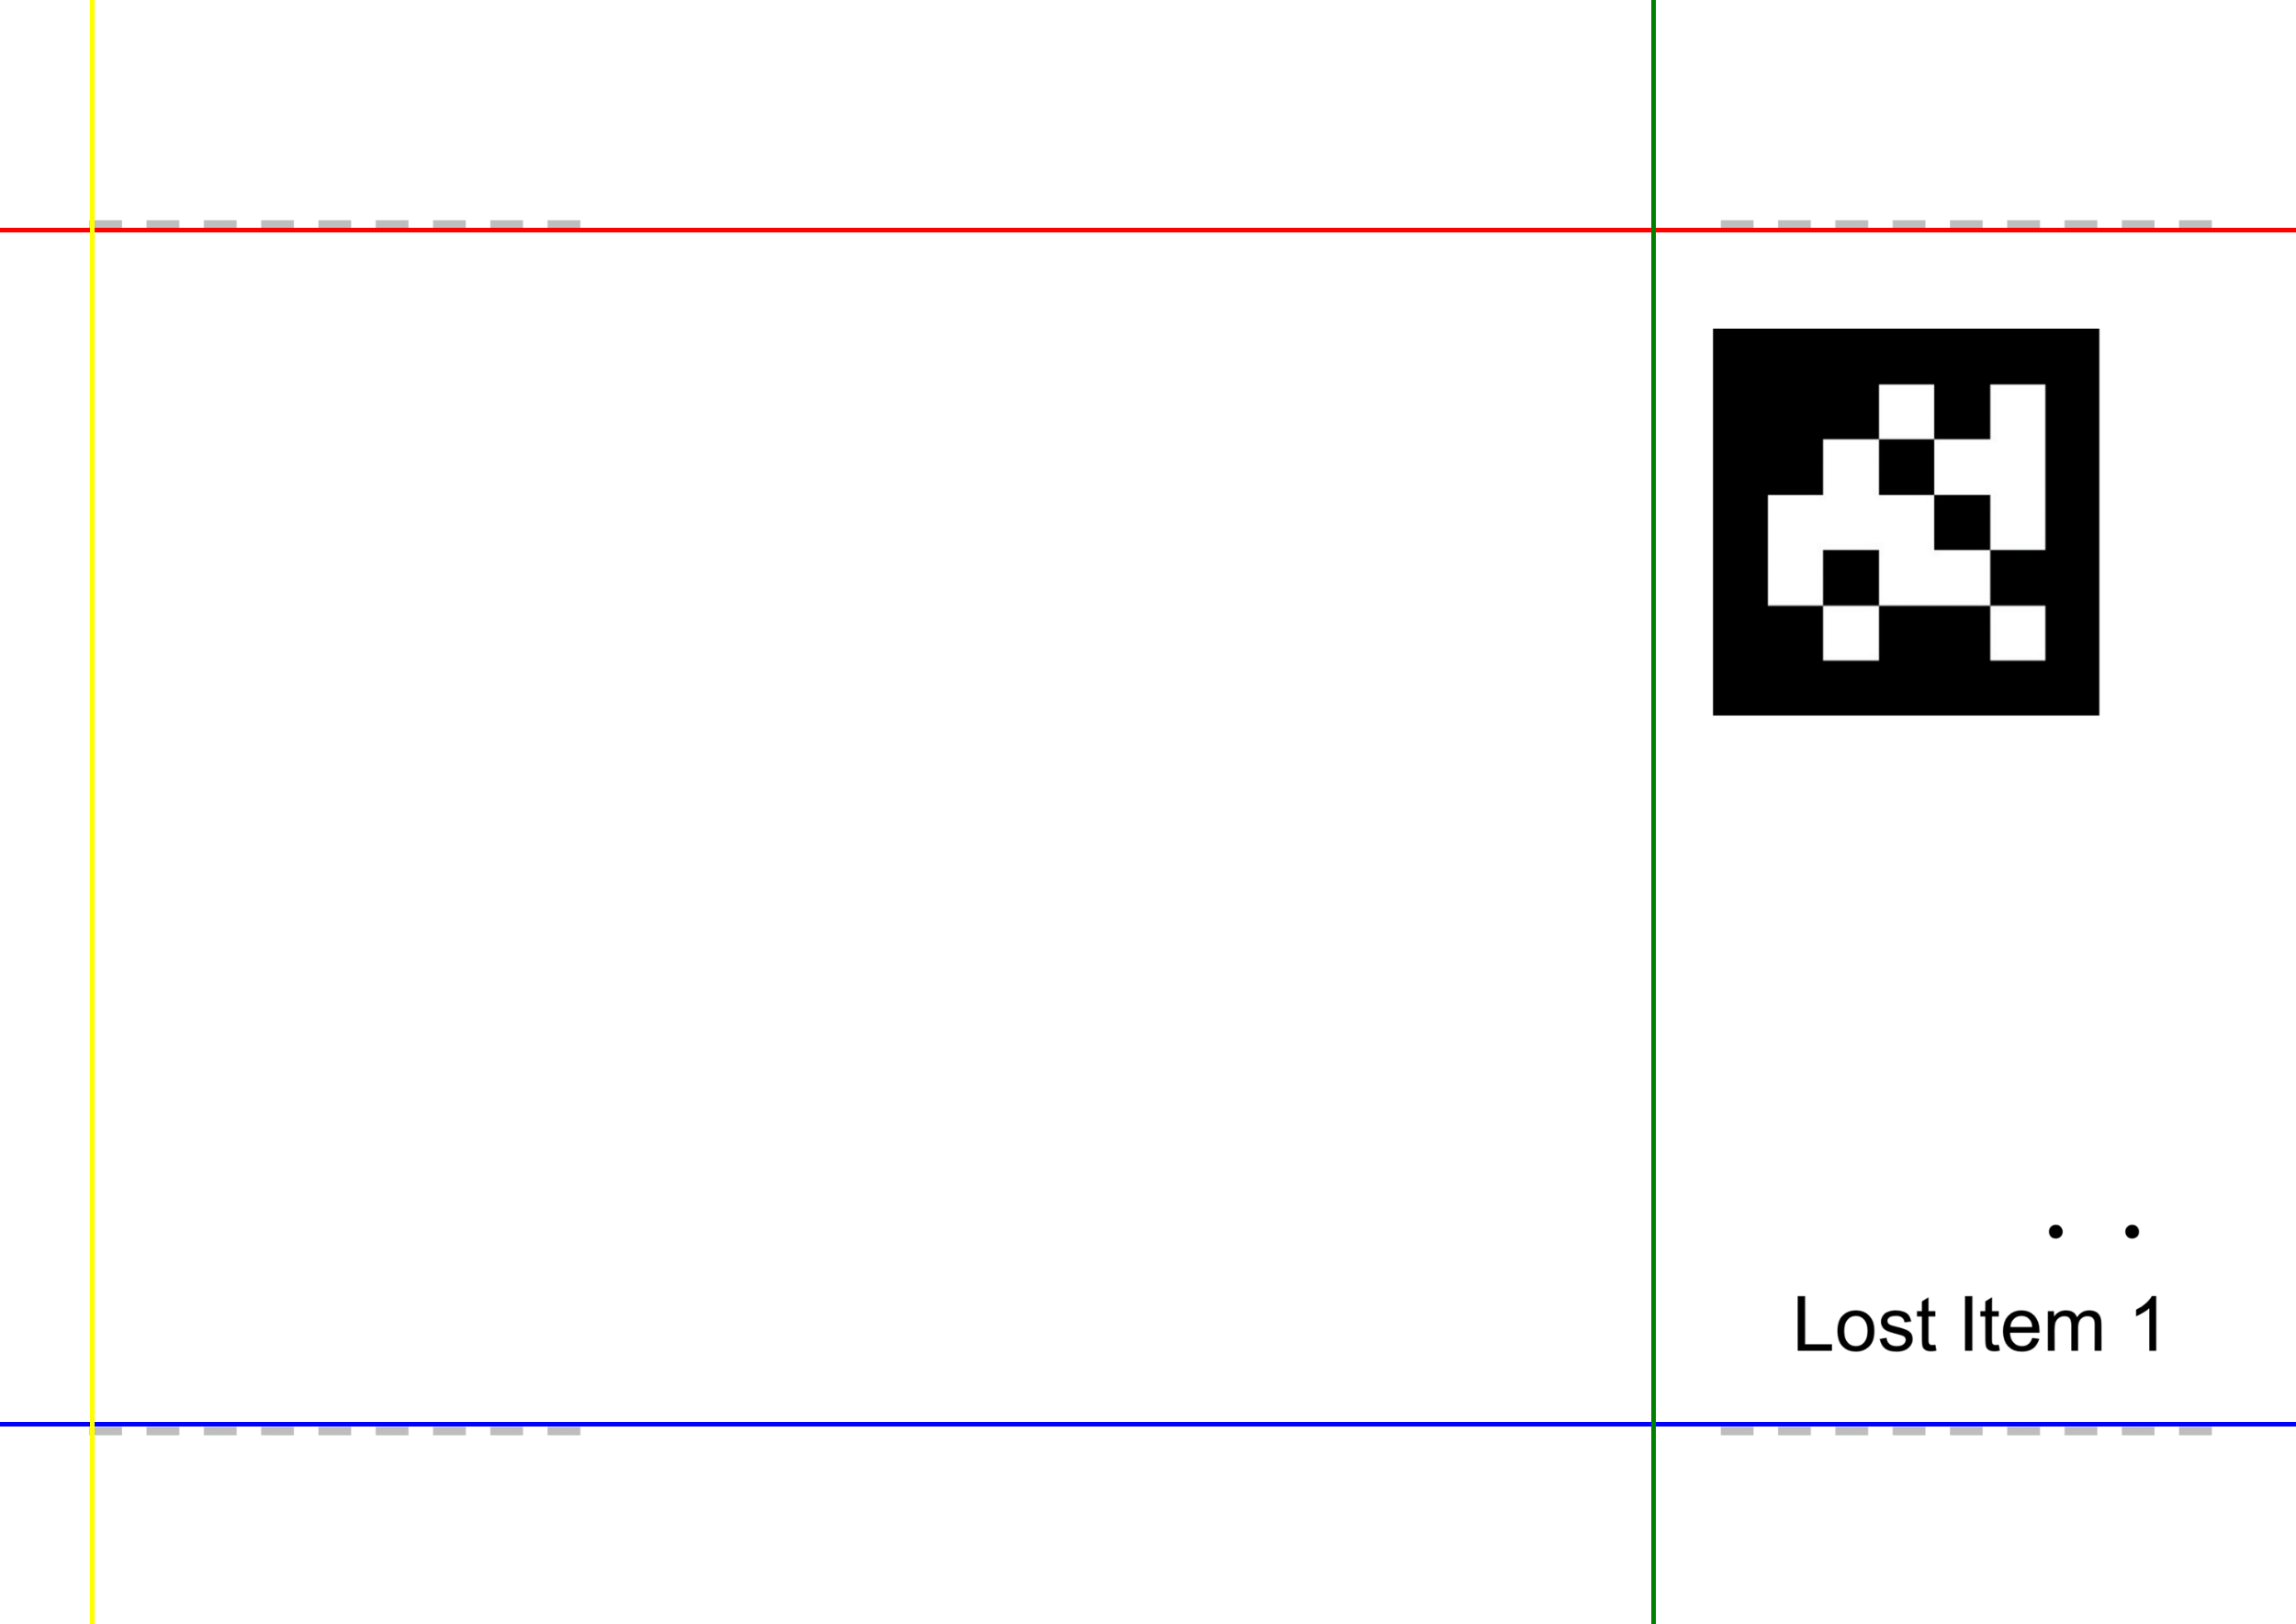

In [38]:
from PIL import Image, ImageDraw
img = Image.open("back/1.png")  # or Image.new("RGB", (400, 300), "white")
draw = ImageDraw.Draw(img)

start_point = (0, 250)   # (x0, y0)
end_point   = (2500, 250) # (x1, y1)
draw.line([start_point, end_point], fill="red", width=5)

start_point = (0, 1550)   # (x0, y0)
end_point   = (2500, 1550) # (x1, y1)
draw.line([start_point, end_point], fill="blue", width=5)


start_point = (1800, 0)   # (x0, y0)
end_point   = (1800, 1768) # (x1, y1)
draw.line([start_point, end_point], fill="green", width=5)

start_point = (100, 0)   # (x0, y0)
end_point   = (100, 1768) # (x1, y1)
draw.line([start_point, end_point], fill="yellow", width=5)

display(img)
# img.show()


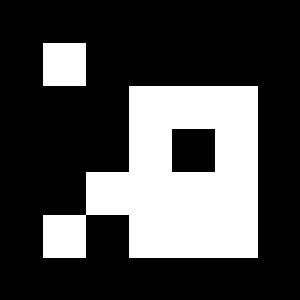

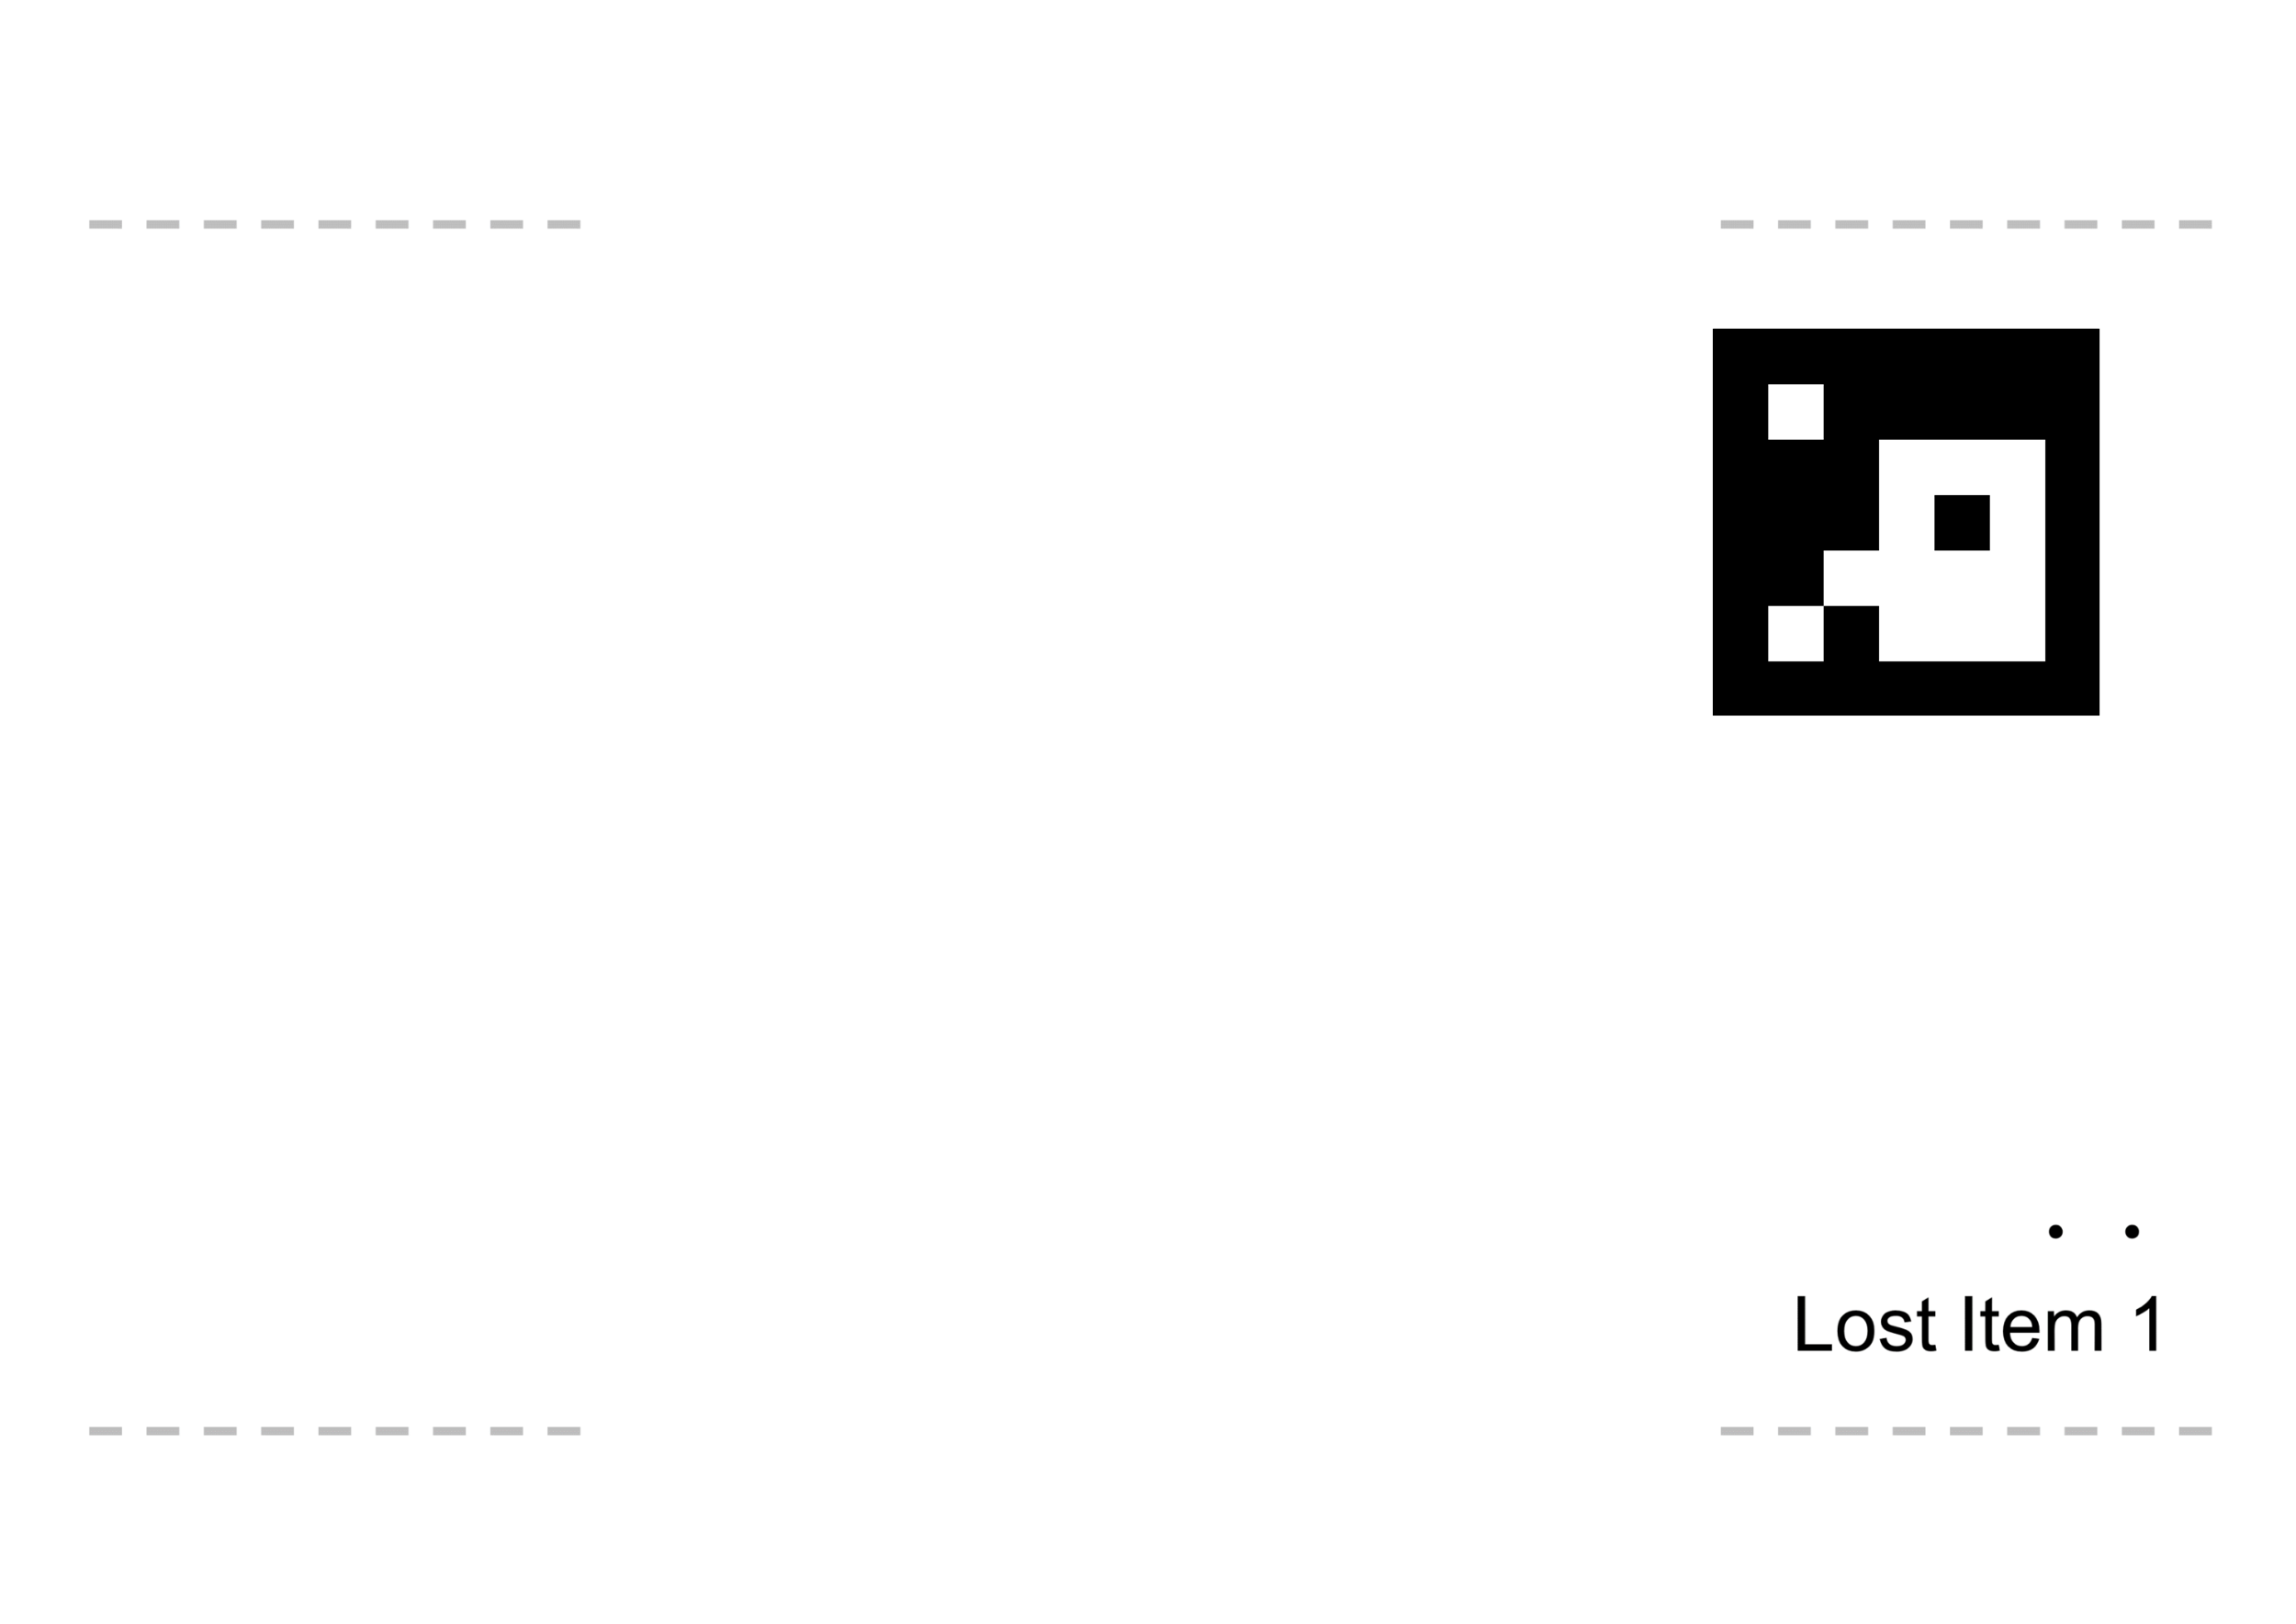

In [ ]:
import random
from PIL import Image


# Define the dictionary
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_5X5_250)

# Set marker ID and size
marker_id = random.randint(1, 20)  # Random ID between 1 and 1000
marker_size = 300  # pixels

# Create an empty image to draw the marker
marker_image = np.zeros((marker_size, marker_size), dtype=np.uint8)

# Generate the marker image
aruco.generateImageMarker(aruco_dict, marker_id, marker_size, marker_image, 1)

# Save the image
cv2.imwrite("aruco_5x5_250_id42.png", marker_image)

# Open the background and the image to overlay
background = Image.open(r"back\1.png").convert("RGBA")
overlay = Image.open("aruco_5x5_250_id42.png").convert("RGBA")  # PNG supports transparency

# Display the modified image
display(overlay)

# Resize overlay if needed
overlay = overlay.resize((421, 421))  # Example: resize to 100x100

# Define position (x, y)
position = (1865, 358)

# Paste overlay onto background
background.paste(overlay, position, overlay)  # The third argument handles transparency
display(background)
# Save or show the result
# background.save("result.png")
# background.show()


In [47]:
from tqdm import tqdm

for i in tqdm(range(10)):
    pass



100%|██████████| 10/10 [00:00<?, ?it/s]


In [1]:
from PIL import Image
import numpy as np
import cv2
import random
import os
from tqdm import tqdm

# Paths
background_path = r"back\1.png"
icon_dir        = r"assets"
output_dir      = "output"
os.makedirs(output_dir, exist_ok=True)
target_size = (416, 416)

# Class labels
class_labels = {
    0: "coin",
    1: "compass",
    2: "coral",
    3: "crystal",
    4: "diamond",
    5: "emerald",
    6: "fossil",
    7: "key",
    8: "letter",
    9: "shell",
    10: "treasure_box"
}

# Global counter to track class usage
class_counts = {cls: 0 for cls in class_labels}

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0

def random_perspective_matrix(width, height, margin=400):
    src = np.float32([[0,0],[width-1,0],[width-1,height-1],[0,height-1]])
    dst = np.float32([
        [random.randint(-margin, margin), random.randint(-margin, margin)],
        [width-1 + random.randint(-margin, margin), random.randint(-margin, margin)],
        [width-1 + random.randint(-margin, margin), height-1 + random.randint(-margin, margin)],
        [random.randint(-margin, margin), height-1 + random.randint(-margin, margin)]
    ])
    return cv2.getPerspectiveTransform(src, dst)

def add_gaussian_noise(image, sigma=random.randint(15, 30)):
    gauss = np.random.normal(0, sigma, image.shape).astype(np.int16)
    noisy = np.clip(image.astype(np.int16) + gauss, 0, 255).astype(np.uint8)
    return noisy

def add_salt_pepper_noise(img, prob = random.uniform(0.05, 0.1)):
    output = img.copy()
    if img.ndim == 2:
        black, white = 0, 255
    else:
        ch = img.shape[2]
        black = np.array([0]*ch, dtype='uint8')
        white = np.array([255]*ch, dtype='uint8')
    probs = np.random.random(output.shape[:2])
    output[probs < (prob/2)] = black
    output[probs > 1 - (prob/2)] = white
    return output

def add_speckle_noise(image, amount=0.002):
    noisy = image.copy()
    h, w = noisy.shape[:2]
    num = int(amount * h * w)
    ys = np.random.randint(0, h, num)
    xs = np.random.randint(0, w, num)
    noisy[ys, xs, :3] = 255
    ys = np.random.randint(0, h, num)
    xs = np.random.randint(0, w, num)
    noisy[ys, xs, :3] = 0
    return noisy

def choose_balanced_classes(count):
    global class_counts
    weights = [1.0/(class_counts[c]+1) for c in class_labels]
    total = sum(weights)
    probs = [w/total for w in weights]
    chosen = []
    for _ in range(count):
        cls = random.choices(list(class_labels.keys()), weights=probs, k=1)[0]
        chosen.append(cls)
        class_counts[cls] += 1
        # update weights & probs
        idx = list(class_labels.keys()).index(cls)
        weights[idx] = 1.0/(class_counts[cls]+1)
        total = sum(weights)
        probs = [w/total for w in weights]
    return chosen

def generate_image(idx,
                   num_items_range=(3,6),
                   max_iou=0.1,
                   max_attempts=30):
    # 1) Load background
    bg = Image.open(background_path).convert("RGBA")
    w_bg, h_bg = bg.size

    # 2) Choose classes balanced across images
    count = random.randint(*num_items_range)
    classes_to_place = choose_balanced_classes(count)

    raw_boxes = []
    for cls in classes_to_place:
        files = [f for f in os.listdir(icon_dir)
                 if f.lower().endswith(('.png','.jpg')) and class_labels[cls] in f.lower()]
        if not files:
            continue

        icon = Image.open(os.path.join(icon_dir, random.choice(files))).convert("RGBA")
        size = random.randint(200,500)
        icon = icon.resize((size,size), Image.BICUBIC)
        rot = icon.rotate(random.uniform(0,360), expand=True)
        bbox = rot.getbbox()
        w_i, h_i = bbox[2]-bbox[0], bbox[3]-bbox[1]

        placed = False
        for _ in range(max_attempts):
            x = random.randint(100, 1800-w_i)
            y = random.randint(250, 1550-h_i)
            new_box = (x, y, x+w_i, y+h_i)
            if not raw_boxes or all(compute_iou(new_box, ob[1:]) <= max_iou for ob in raw_boxes):
                placed = True
                break

        if not placed:
            x = random.randint(100, 1800-w_i)
            y = random.randint(250, 1550-h_i)
            new_box = (x, y, x+w_i, y+h_i)

        bg.paste(rot, (x - bbox[0], y - bbox[1]), rot)
        raw_boxes.append((cls, *new_box))

    # 3) Perspective warp
    bg_cv = cv2.cvtColor(np.array(bg), cv2.COLOR_RGBA2BGRA)
    M = random_perspective_matrix(w_bg, h_bg)
    warped = cv2.warpPerspective(bg_cv, M, (w_bg, h_bg),
                                 borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=(0,0,0,0))

    # 4) Add noise
    warped = add_gaussian_noise(warped)
    warped = add_speckle_noise(warped)
    warped = add_salt_pepper_noise(warped)

    # 5) Resize image to 416x416
    warped = cv2.resize(warped, target_size, interpolation=cv2.INTER_LINEAR)

    # 6) Recompute & save boxes
    lines = []
    for cls, x0, y0, x1, y1 in raw_boxes:
        # prepare corner points
        pts = np.array([[[x0,y0]],[[x1,y0]],[[x1,y1]],[[x0,y1]]], dtype=np.float32)
        warped_pts = cv2.perspectiveTransform(pts, M).reshape(-1,2)
        xs, ys = warped_pts[:,0], warped_pts[:,1]

        # axis-aligned bounding box in warped space
        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()

        # scale to target_size
        sx = target_size[0] / w_bg
        sy = target_size[1] / h_bg
        xmin, xmax = xmin * sx, xmax * sx
        ymin, ymax = ymin * sy, ymax * sy

        # clip to image bounds
        xmin, ymin = max(0, xmin), max(0, ymin)
        xmax, ymax = min(target_size[0], xmax), min(target_size[1], ymax)

        # normalize for YOLO
        xc = ((xmin + xmax) / 2) / target_size[0]
        yc = ((ymin + ymax) / 2) / target_size[1]
        wn = (xmax - xmin) / target_size[0]
        hn = (ymax - ymin) / target_size[1]

        lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n")

    # write files
    img_out = os.path.join(output_dir, f"image_{idx}.png")
    lbl_out = os.path.join(output_dir, f"image_{idx}.txt")
    cv2.imwrite(img_out, cv2.cvtColor(warped, cv2.COLOR_BGRA2BGR))
    with open(lbl_out, "w") as f:
        f.writelines(lines)

if __name__ == "__main__":
    for i in tqdm(range(1, 100)):
        generate_image(i, num_items_range=(4,7), max_iou=1, max_attempts=40)


100%|██████████| 99/99 [00:59<00:00,  1.67it/s]
